# LDA

In [1]:
# Importing necessary libraries
from ucimlrepo import fetch_ucirepo
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Fetch the Adult dataset from UCI ML repository
adult = fetch_ucirepo(id=2)

In [2]:
# Separate features and targets
X = adult.data.features
y = adult.data.targets

# Replace '?' with NaN in X
X.replace('?', np.nan, inplace=True)

# Clean the target variable (income)
y.loc[:, y.columns[0]] = y[y.columns[0]].replace({'<=50K.': '<=50K', '>50K.': '>50K'})

# Ensure the split maintains the proportion of 'sex' in the test set
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, stratify=X['sex'], random_state=42
)

# Drop rows with missing data (NaN values) from X_test and ensure y_test is consistent
X_test = X_test_raw.dropna()
y_test = y_test_raw.loc[X_test.index]

# Subtract X_test from the original dataset to get X_train
X_train = X.drop(X_test.index)
y_train = y.drop(y_test.index)

# Display the proportion of 'sex' in the overall dataset, training, and test sets
overall_sex_proportion = X['sex'].value_counts(normalize=True)
train_sex_proportion = X_train['sex'].value_counts(normalize=True)
test_sex_proportion = X_test['sex'].value_counts(normalize=True)

# Print the proportions
print("Proportion of data by sex: overall data (before split), training data, test data.")
print("Overall sex proportion:\n", overall_sex_proportion)
print("Training set sex proportion:\n", train_sex_proportion)
print("Test set sex proportion:\n", test_sex_proportion)

Proportion of data by sex: overall data (before split), training data, test data.
Overall sex proportion:
 sex
Male      0.668482
Female    0.331518
Name: proportion, dtype: float64
Training set sex proportion:
 sex
Male      0.666466
Female    0.333534
Name: proportion, dtype: float64
Test set sex proportion:
 sex
Male      0.677327
Female    0.322673
Name: proportion, dtype: float64


C:\Users\milse\AppData\Local\Temp\ipykernel_45628\1231798606.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace('?', np.nan, inplace=True)


In [3]:
# Count the number of missing values in X_train and X_test
missing_in_train = X_train.isna().sum()
missing_in_test = X_test.isna().sum()

# Count the total number of missing values in each dataset
total_missing_train = X_train.isna().sum().sum()
total_missing_test = X_test.isna().sum().sum()

# Print the number of missing data in each set
print("\nNumber of missing values in each feature (training set):")
print(missing_in_train)

print("\nNumber of missing values in each feature (test set):")
print(missing_in_test)


Number of missing values in each feature (training set):
age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
dtype: int64

Number of missing values in each feature (test set):
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
dtype: int64


In [4]:
# Create a 'data' directory in the parent directory if it doesn't exist
os.makedirs("../data", exist_ok=True)

# Save X_train, y_train, X_test, and y_test to separate CSV files
X_train.to_csv("../data/X_train.csv", index=True)        # Save features of train set
y_train.to_csv("../data/y_train.csv", index=True)        # Save targets of train set
X_test.to_csv("../data/X_test.csv", index=True)          # Save features of test set
y_test.to_csv("../data/y_test.csv", index=True)          # Save targets of test set

"Datasets saved as '../data/X_train.csv', '../data/y_train.csv', '../data/X_test.csv', and '../data/y_test.csv' with index."

"Datasets saved as '../data/X_train.csv', '../data/y_train.csv', '../data/X_test.csv', and '../data/y_test.csv' with index."

In [5]:
# Load the saved datasets from the CSV files
X_train = pd.read_csv("../data/X_train.csv", index_col=0)  # Use the first column as index
y_train = pd.read_csv("../data/y_train.csv", index_col=0)  # Use the first column as index
X_test = pd.read_csv("../data/X_test.csv", index_col=0)    # Use the first column as index
y_test = pd.read_csv("../data/y_test.csv", index_col=0)    # Use the first column as index

# Display the first few rows of the loaded datasets
(X_train.head(), y_train.head(), X_test.head(), y_test.head())

(   age         workclass  fnlwgt  education  education-num  \
 0   39         State-gov   77516  Bachelors             13   
 1   50  Self-emp-not-inc   83311  Bachelors             13   
 2   38           Private  215646    HS-grad              9   
 3   53           Private  234721       11th              7   
 4   28           Private  338409  Bachelors             13   
 
        marital-status         occupation   relationship   race     sex  \
 0       Never-married       Adm-clerical  Not-in-family  White    Male   
 1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
 2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
 3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
 4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   
 
    capital-gain  capital-loss  hours-per-week native-country  
 0          2174             0              40  United-States  
 1             0             0          

## Checks

In [6]:
# Load the saved datasets from the CSV files
X_train_loaded = pd.read_csv("../data/X_train.csv", index_col=0)  # Use the first column as index
y_train_loaded = pd.read_csv("../data/y_train.csv", index_col=0)  # Use the first column as index
X_test_loaded = pd.read_csv("../data/X_test.csv", index_col=0)    # Use the first column as index
y_test_loaded = pd.read_csv("../data/y_test.csv", index_col=0)    # Use the first column as index

# Display the first few rows of the loaded datasets
(X_train_loaded.head(), y_train_loaded.head(), X_test_loaded.head(), y_test_loaded.head())

# Compare loaded data with original data
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, stratify=X['sex'], random_state=42
)
X_test = X_test_raw.dropna()
y_test = y_test_raw.loc[X_test.index]
X_train = X.drop(X_test.index)
y_train = y.drop(y_test.index)

# Check if the original and loaded training feature sets are equal
X_train_comparison = X_train_loaded.equals(X_train)
y_train_comparison = y_train_loaded.equals(y_train)

# Check if the original and loaded test feature sets are equal
X_test_comparison = X_test_loaded.equals(X_test)
y_test_comparison = y_test_loaded.equals(y_test)

# Create a summary of the comparisons
comparison_results = {
    'X_train_equal': X_train_comparison,
    'y_train_equal': y_train_comparison,
    'X_test_equal': X_test_comparison,
    'y_test_equal': y_test_comparison,
}

# Print out the comparison results
for key, value in comparison_results.items():
    print(f"{key}: {value}")

# If any discrepancies found, print the first few mismatched rows
if not X_train_comparison:
    print("\nMismatched rows in X_train:")
    print(X_train_loaded[X_train_loaded != X_train].dropna())

if not y_train_comparison:
    print("\nMismatched values in y_train:")
    print(y_train_loaded[y_train_loaded != y_train].dropna())

if not X_test_comparison:
    print("\nMismatched rows in X_test:")
    print(X_test_loaded[X_test_loaded != X_test].dropna())

if not y_test_comparison:
    print("\nMismatched values in y_test:")
    print(y_test_loaded[y_test_loaded != y_test].dropna())

X_train_equal: True
y_train_equal: True
X_test_equal: True
y_test_equal: True


## LDA START

In [7]:
# Step 1: One-hot encode categorical variables
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Step 2: Align the test set with the training set to handle missing categories
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1)

# Step 3: Fill missing values in the test set with 0
X_test_encoded.fillna(0, inplace=True)

# Step 4: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Step 5: Fit the LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)

# Step 6: Predict on the test set
y_pred = lda.predict(X_test_scaled)

# Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, pos_label='>50K')
recall = recall_score(y_test, y_pred, pos_label='>50K')
f1 = f1_score(y_test, y_pred, pos_label='>50K')

# Print results
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

C:\Users\milse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8398764887516542
Confusion Matrix:
[[6357  505]
 [ 947 1259]]
Precision: 0.713718820861678
Recall: 0.570716228467815
F1-Score: 0.6342569269521411


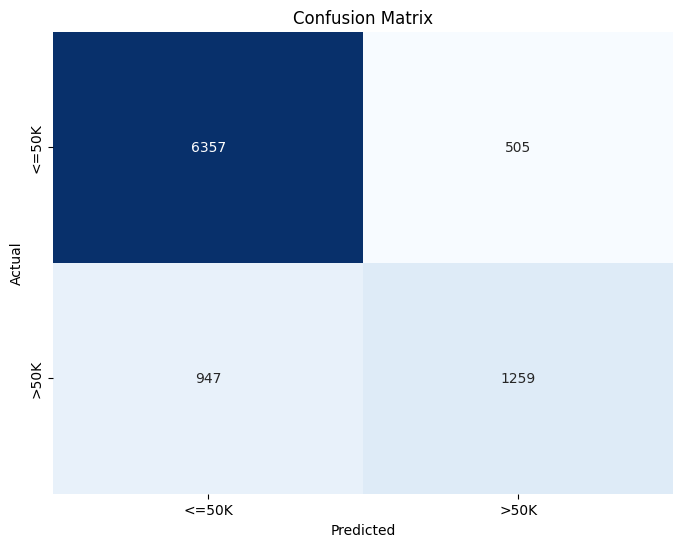

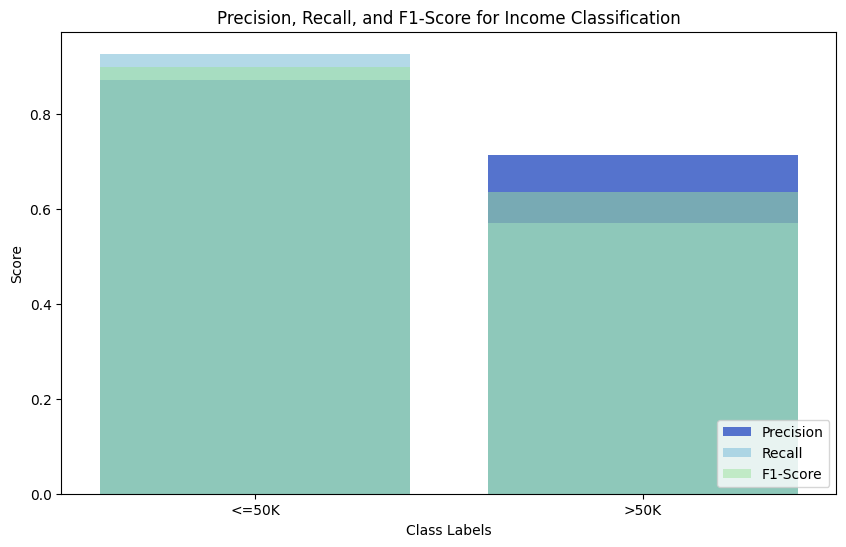

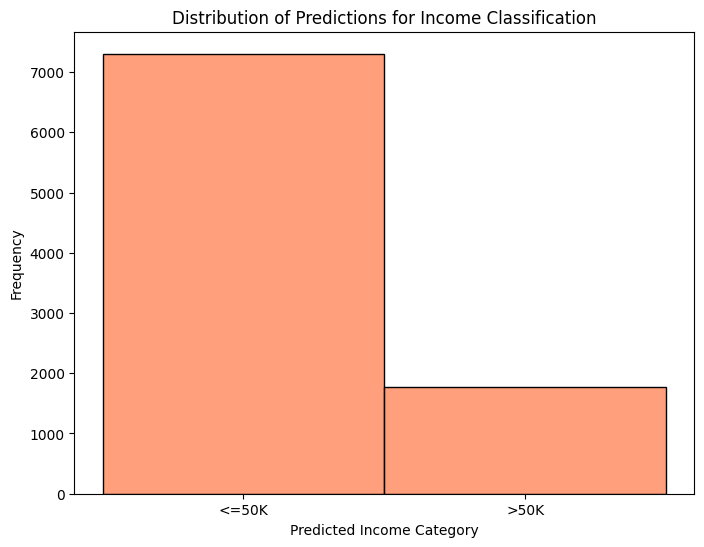

In [8]:
# Step 1: Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 2: Plotting Precision, Recall, F1-Score from Classification Report
# Get classification report as dictionary
class_report = classification_report(y_test, y_pred, output_dict=True)

# Convert to DataFrame for Seaborn visualization
class_report_df = pd.DataFrame(class_report).transpose()

# Plot barplot for precision, recall, and f1-score
plt.figure(figsize=(10, 6))
sns.barplot(x=class_report_df.index[:-3], y=class_report_df['precision'][:-3], color='royalblue', label='Precision')
sns.barplot(x=class_report_df.index[:-3], y=class_report_df['recall'][:-3], color='skyblue', label='Recall', alpha=0.7)
sns.barplot(x=class_report_df.index[:-3], y=class_report_df['f1-score'][:-3], color='lightgreen', label='F1-Score', alpha=0.5)

plt.title("Precision, Recall, and F1-Score for Income Classification")
plt.legend(loc="lower right")
plt.xlabel("Class Labels")
plt.ylabel("Score")
plt.show()

# Step 3: Visualizing Distribution of Predictions
plt.figure(figsize=(8, 6))
sns.histplot(y_pred, kde=False, color='coral')
plt.title("Distribution of Predictions for Income Classification")
plt.xlabel("Predicted Income Category")
plt.ylabel("Frequency")
plt.show()

Cross-Validation Accuracy: 0.841655352742998


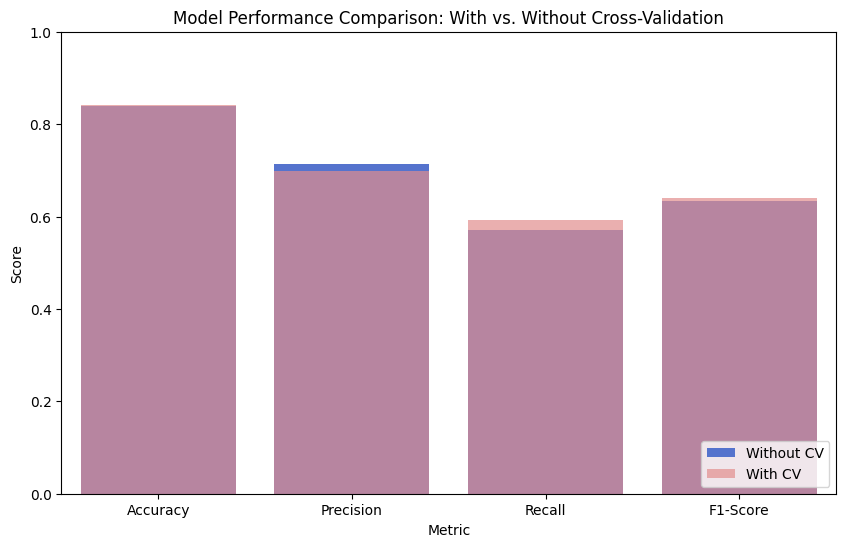

Classification Report with Cross-Validation:
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90     30293
        >50K       0.70      0.59      0.64      9481

    accuracy                           0.84     39774
   macro avg       0.79      0.76      0.77     39774
weighted avg       0.84      0.84      0.84     39774



In [9]:
# Initialize the LDA model
lda = LinearDiscriminantAnalysis()

# Step 1: Perform cross-validation and obtain predictions for each fold
# Use .values or .to_numpy() to convert y_train to a 1D array
y_pred_cv = cross_val_predict(lda, X_train_scaled, y_train.values.ravel(), cv=5)

# Step 2: Calculate accuracy scores
cv_accuracy = np.mean(y_pred_cv == y_train.values.ravel())
print(f"Cross-Validation Accuracy: {cv_accuracy}")

# Step 3: Generate classification report
cv_class_report = classification_report(y_train, y_pred_cv, output_dict=True)
cv_class_report_df = pd.DataFrame(cv_class_report).transpose()

# Step 4: Prepare for visualization
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Without CV': [
        accuracy,
        class_report_df.loc['>50K', 'precision'],
        class_report_df.loc['>50K', 'recall'],
        class_report_df.loc['>50K', 'f1-score']
    ],
    'With CV': [
        cv_accuracy,
        cv_class_report_df.loc['>50K', 'precision'],
        cv_class_report_df.loc['>50K', 'recall'],
        cv_class_report_df.loc['>50K', 'f1-score']
    ]
})

# Step 5: Plotting Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Without CV', data=metrics_df, color='royalblue', label='Without CV')
sns.barplot(x='Metric', y='With CV', data=metrics_df, color='lightcoral', label='With CV', alpha=0.7)

plt.title("Model Performance Comparison: With vs. Without Cross-Validation")
plt.ylabel("Score")
plt.legend(loc="lower right")
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.show()

# Step 6: Display classification reports for reference
# Ensure to use y_pred_cv (from cross-validation) instead of y_pred
print("Classification Report with Cross-Validation:")
print(classification_report(y_train.values.ravel(), y_pred_cv))

C:\Users\milse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


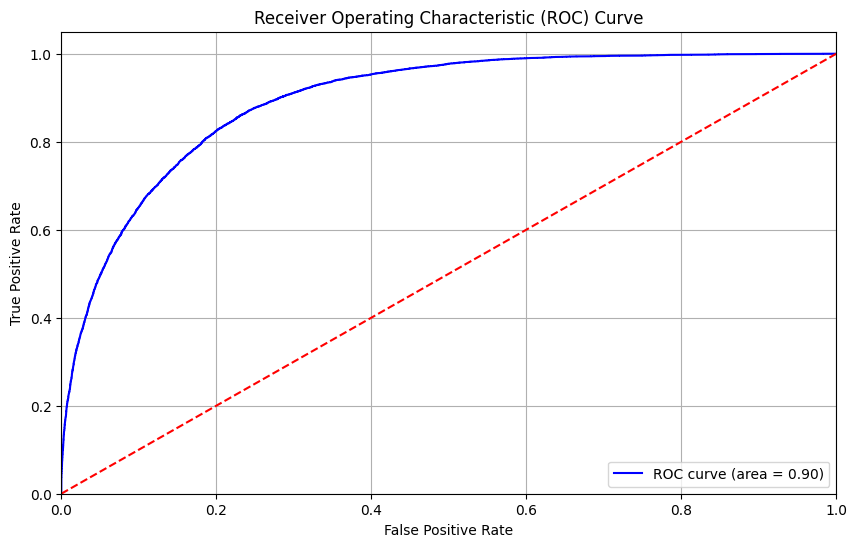

In [10]:
# Step 1: Fit the LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)  # Ensure you fit the model first

# Step 2: Get predicted probabilities for the positive class
y_pred_prob = lda.predict_proba(X_train_scaled)[:, 1]  # Get probabilities for the >50K class

# Step 3: Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob, pos_label='>50K')
roc_auc = auc(fpr, tpr)  # Calculate the area under the ROC curve

# Step 4: Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()